## Extract information from Covid literature

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import wordcloud as wd
import glob
import json
import re
import string
import warnings
warnings.filterwarnings("ignore")

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sentence_transformers import SentenceTransformer
import scipy.spatial
import pickle as pkl

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from collections import Counter
warnings.filterwarnings("ignore")

In [2]:
import scispacy
import spacy
from spacy.lang.en import English
import string
import en_core_sci_sm 
import en_core_sci_lg#The model we are going to use
from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.umls_linking import UmlsEntityLinker

## Read files into jupyter notebook

In [3]:
files = glob.glob('CORD-19-research-challenge/all_json/pdf_json/*.json',  
                   recursive = True)

def file_reader(files):
    '''
    read json files, extract text data from it
    and return as list
    '''
    full_doc = []
    for file in files:
        
        with open(file) as f: #load Json file
            content = json.load(f)
            
            #Get paperid
            paper_id = content["paper_id"]
            
            #Get title
            title = content['metadata']['title']
            
            # Get Abstract
            try:
                for cont in content['abstract']:
                    abstract = cont["text"]
            except:
                abstract = ""
                
            #Get Body_text
            full_text = ""
            for cont in content["body_text"]:
                full_text += cont["text"]+"\n\n"
                
            #Get all data together
            full_doc.append([paper_id,title,abstract,full_text])
            
    return full_doc
    

In [4]:
print(len(files))
data = file_reader(files)
df = pd.DataFrame(data, columns = ["paper_id", "title", 
                                   "abstract", "full_text"])
print(df.shape)

47900
(47900, 4)


## Filtering articles that are related to corona virus

In [5]:
df1 = df[df["title"].str.contains("corona")]
df2 = df[df["title"].str.contains("Corona")]
df3 = df[df["title"].str.contains("Covid-19")]
df4 = df[df["title"].str.contains("covid-19")]
df5 = df[df["full_text"].str.contains("novel corona")]
df6 = df[df["title"].str.contains("novel corona")]
df7 = df[df["full_text"].str.contains("SARS-CoV-2")]
novel_corona = pd.concat([df1,df2,df3,df4,df5,df6,df7]) 
covid = novel_corona.drop_duplicates()
print(novel_corona.shape,covid.shape)

(8981, 4) (7057, 4)


In [6]:
covid = covid.reset_index()

In [16]:
from spacy_langdetect import LanguageDetector
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)


def detect_lang(text):
    '''
    function to detect language and return 
    lang type
    '''
    doc = nlp(text)
    return doc._.language['language'] 

#apply to the data frame so that each article language is detected
covid["language"] = covid["abstract"].apply(lambda x: detect_lang(x))
covid.head()


,index,paper_id,title,abstract,full_text,language
0,3,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,A Novel Approach for a Novel Pathogen: using a...,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...",en
1,21,7f1d647d43af4ed96625ed113f8bf0ab737e2f0c,Severe acute respiratory syndrome vaccine deve...,Vaccines against infectious bronchitis of chic...,Severe acute respiratory syndrome (SARS) emerg...,en
2,25,72267ff359743ab2f111042d9cc5f9dd5f14fe79,SARS coronavirus: Unusual lability of the nucl...,"Fur ther more, results of subsequent test ing ...",Severe acute respi ra tory syn drome (SARS) is...,en
3,26,3a16486a83cdb5e7d03a39f376219a97591eaadc,Evaluation of an in-practice test for feline c...,A negative result with the in-practice assay i...,Feline coronavirus (FCoV) is a ubiquitous infe...,en
4,51,0a9a85b82e17c880c923b5de9bec22931ed76f13,A line immunoassay utilizing recombinant nucle...,Most coronaviruses infecting humans cause mild...,"Coronaviruses (family Coronaviridae, order Nid...",en


In [18]:
print(covid["language"].unique())
covid1 = covid[covid["language"] == "en"] 
len(covid1)

['en' 'UNKNOWN' 'cy' 'ca' 'de' 'vi' 'nl' 'fr' 'es' 'af' 'pt' 'tl' 'et'
 'ro' 'fi' 'sw' 'it' 'so']


5576

## Text Preprocessing

- Using spacy for the text pre-processing.
- Using en_core_sci_lg, a spacy's model for scientific and medical     documents. 


In [22]:
#select punctuations
punctuations = string.punctuation

#select stop words and make custom stop words
stopwords = list(STOP_WORDS)
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'preprint',
                     'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 
                     'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www',
                    'peer-reviewed', 'author/funder', 'grant', 'https://doi', 'author funder', 'doi org',
                    'table', 'grant display', 'el', 'doi.org', 'holder' ]
for word in custom_stop_words:
    if word not in stopwords:
        stopwords.append(word)

In [23]:
nlp = spacy.load("en_core_sci_lg")

In [24]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [25]:
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
def spacy_tokenizer(sentence):
    '''
    parses text
    lemmatization
    removes stop words
    
    '''
    mytokens = parser(sentence)
    #Pronouns (like "I" and "you" get lemmatized to '-PRON-', so removing those.
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [26]:
from tqdm.notebook import tqdm
tqdm.pandas()
covid1["processed_fulltext"] = covid1["full_text"].progress_apply(spacy_tokenizer)
covid1.head()

,index,paper_id,title,abstract,full_text,language,processed_fulltext
0,3,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,A Novel Approach for a Novel Pathogen: using a...,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...",en,2019 novel coronavirus sars-cov-2 identify cau...
1,21,7f1d647d43af4ed96625ed113f8bf0ab737e2f0c,Severe acute respiratory syndrome vaccine deve...,Vaccines against infectious bronchitis of chic...,Severe acute respiratory syndrome (SARS) emerg...,en,severe acute respiratory syndrome sars emerge ...
2,25,72267ff359743ab2f111042d9cc5f9dd5f14fe79,SARS coronavirus: Unusual lability of the nucl...,"Fur ther more, results of subsequent test ing ...",Severe acute respi ra tory syn drome (SARS) is...,en,severe acute respi ra tory syn drome sars atyp...
3,26,3a16486a83cdb5e7d03a39f376219a97591eaadc,Evaluation of an in-practice test for feline c...,A negative result with the in-practice assay i...,Feline coronavirus (FCoV) is a ubiquitous infe...,en,feline coronavirus fcov ubiquitous infection c...
4,51,0a9a85b82e17c880c923b5de9bec22931ed76f13,A line immunoassay utilizing recombinant nucle...,Most coronaviruses infecting humans cause mild...,"Coronaviruses (family Coronaviridae, order Nid...",en,coronaviruses family coronaviridae order nidov...


In [27]:
#pickle covid1 data
import pickle
with open("covid1.pickle", "wb") as file:
    pickle.dump(covid1, file)
    file.close() 

In [28]:
covid1.head()

,index,paper_id,title,abstract,full_text,language,processed_fulltext
0,3,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,A Novel Approach for a Novel Pathogen: using a...,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...",en,2019 novel coronavirus sars-cov-2 identify cau...
1,21,7f1d647d43af4ed96625ed113f8bf0ab737e2f0c,Severe acute respiratory syndrome vaccine deve...,Vaccines against infectious bronchitis of chic...,Severe acute respiratory syndrome (SARS) emerg...,en,severe acute respiratory syndrome sars emerge ...
2,25,72267ff359743ab2f111042d9cc5f9dd5f14fe79,SARS coronavirus: Unusual lability of the nucl...,"Fur ther more, results of subsequent test ing ...",Severe acute respi ra tory syn drome (SARS) is...,en,severe acute respi ra tory syn drome sars atyp...
3,26,3a16486a83cdb5e7d03a39f376219a97591eaadc,Evaluation of an in-practice test for feline c...,A negative result with the in-practice assay i...,Feline coronavirus (FCoV) is a ubiquitous infe...,en,feline coronavirus fcov ubiquitous infection c...
4,51,0a9a85b82e17c880c923b5de9bec22931ed76f13,A line immunoassay utilizing recombinant nucle...,Most coronaviruses infecting humans cause mild...,"Coronaviruses (family Coronaviridae, order Nid...",en,coronaviruses family coronaviridae order nidov...


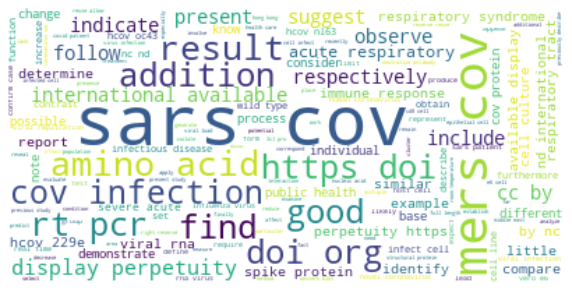

In [30]:
from wordcloud import WordCloud,ImageColorGenerator
#combine all full_text into one document
text = " ".join([text for text in covid1["processed_fulltext"]])

#Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size = 50, 
                      background_color= "white").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Topic Modelling with LDA

Make text usable for gensim:
- Document lemmatised, removed stop words and cleaned punctuations using spacy
- Make each document into tokens so that can be usable with Gensim.


### Base model

In [31]:
import gensim
from gensim import corpora, models, similarities, matutils
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [23]:
covid = covid.reset_index()

In [34]:
#make list of list from documents in processed text 
doc_list = []
for row in covid1["processed_fulltext"]:
    doc = row.split(" ")
    doc_list.append(doc)
len(doc_list)  

5576

In [32]:
doc_list[0]

['2019',
 'novel',
 'coronavirus',
 'sars-cov-2',
 'identify',
 'cause',
 'outbreak',
 'respiratory',
 'infection',
 'wuhan',
 'china',
 'rapidly',
 'spread',
 'globe',
 '\ufeff1',
 'case',
 'united',
 'states',
 'identify',
 'january',
 '20',
 'th',
 '2020',
 '1',
 'march',
 '6',
 '2020',
 '164',
 'additional',
 'case',
 'united',
 'states',
 'diagnose',
 'thousand',
 'people',
 'test',
 'sars-cov-2',
 '2',
 'anticipate',
 'require',
 'test',
 'future',
 'transmission',
 'dynamic',
 'sars-cov-2',
 'remain',
 'study',
 'conservative',
 'infection',
 'control',
 'process',
 'intensive',
 'contact',
 'trace',
 'require',
 'confirm',
 'suspect',
 'case',
 'infection',
 'public',
 'health',
 'agency',
 'charge',
 'monitor',
 'person',
 'sars-cov-2',
 'exposure',
 'perform',
 'assessment',
 'symptom',
 'develop',
 'depending',
 'outcome',
 'assessment',
 'test',
 'sars-cov-2',
 'recommend',
 'safe',
 'evaluation',
 'person',
 'suspect',
 'infection',
 'special',
 'pathogen',
 'include',
 's

In [35]:
#Make dictionary Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)
#print(words.token2id)
#Create bag of words from each document in the words
corpus = [words.doc2bow(doc) for doc in doc_list]
print(corpus[0])

[(0, 4), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 2), (9, 2), (10, 2), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 4), (28, 1), (29, 1), (30, 7), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 3), (38, 3), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 2), (60, 2), (61, 3), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 3), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 3), (89, 1), (90, 1), (91, 4), (92, 1), (93, 2), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 3), (102, 1), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 4), (109, 4), (110, 1),

In [36]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=words,
                                            num_topics=5, 
                                            random_state=100,
                                            chunksize= 100,
                                            passes=10,
                                            per_word_topics=True)

In [37]:
import pprint
pprint.pprint(lda_model.print_topics(num_words=20)) 

[(0,
  '0.034*"cell" + 0.011*"virus" + 0.011*"protein" + 0.009*"infection" + '
  '0.007*"antibody" + 0.007*"viral" + 0.007*"expression" + 0.007*"use" + '
  '0.007*"response" + 0.006*"sars-cov" + 0.006*"mouse" + 0.005*"ace2" + '
  '0.005*"t" + 0.005*"immune" + 0.005*"vaccine" + 0.005*"lung" + 0.004*"human" '
  '+ 0.004*"2" + 0.004*"1" + 0.004*"level"'),
 (1,
  '0.021*"sequence" + 0.013*"virus" + 0.009*"use" + 0.009*"rna" + '
  '0.009*"genome" + 0.008*"gene" + 0.008*"sars-cov-2" + 0.007*"viral" + '
  '0.007*"protein" + 0.007*"human" + 0.006*"bat" + 0.005*"analysis" + '
  '0.005*"coronavirus" + 0.005*"host" + 0.005*"1" + 0.005*"region" + '
  '0.004*"identify" + 0.004*"2" + 0.004*"species" + 0.003*"3"'),
 (2,
  '0.014*"protein" + 0.011*"bind" + 0.008*"sars-cov-2" + 0.008*"structure" + '
  '0.007*"use" + 0.007*"residue" + 0.006*"s" + 0.006*"peptide" + 0.006*"2" + '
  '0.005*"1" + 0.005*"ace2" + 0.005*"sars-cov" + 0.005*"interaction" + '
  '0.005*"activity" + 0.004*"inhibitor" + 0.004*"domai

In [39]:
# Get Coherence Score usinf c_v
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=doc_list, 
                                     dictionary=words, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4322944805620376


In [75]:
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=doc_list, 
                                     dictionary=words, 
                                     coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -0.5840984281199797


### Hyper parameter tuning

In [76]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topic in range(start, limit, step):
        model=gensim.models.LdaModel(corpus=corpus,
                                     id2word=dictionary,
                                     num_topics= num_topic, 
                                     random_state=100,
                                     chunksize=100,
                                     passes=10,
                                     per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [77]:
model_list, coherence_values = compute_coherence_values(dictionary=words, 
                                                        corpus=corpus, 
                                                        texts=doc_list, 
                                                        start=2, 
                                                        limit=20, 
                                                        step=3)


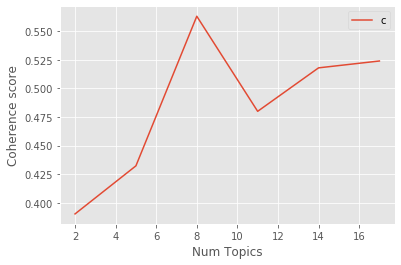

In [79]:
# Show graph
import matplotlib.pyplot as plt
limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
print(model_list,'\n', coherence_values)

[<gensim.models.ldamodel.LdaModel object at 0x1bd521b350>, <gensim.models.ldamodel.LdaModel object at 0x1bb319b4d0>, <gensim.models.ldamodel.LdaModel object at 0x1bb3ffc410>, <gensim.models.ldamodel.LdaModel object at 0x1bcd5cc610>, <gensim.models.ldamodel.LdaModel object at 0x1bb3ffc090>, <gensim.models.ldamodel.LdaModel object at 0x1bc5d21450>] 
 [0.3902498821976087, 0.4322944805620376, 0.5631347124567353, 0.479973836659322, 0.5179921703929063, 0.523996182638029]


- Coherent value for the LDA_model is 0.56 highest for topic number 8 and alpha is symmetric.
- Keeping this topic number constant again running the model with different alpha values would be the next step to make better coherent value

In [100]:
#Get coherence values for different alpha
def compute_coherence_values(dictionary, corpus, texts, alpha, num_topic):
    """
    Compute c_v coherence for various alpha values

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    alpha: list of alpha values
    num_topic: number of topics to be divided

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num in alpha:
        model=gensim.models.LdaModel(corpus=corpus,
                                     id2word=dictionary,
                                     num_topics= num_topic, 
                                     random_state=100,
                                     chunksize=100,
                                     passes=10,
                                     alpha = num,
                                     per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [115]:
model_list, coherence_values = compute_coherence_values(dictionary=words, 
                                                        corpus=corpus, 
                                                        texts=doc_list,
                                                        alpha = list(np.arange(0.01, 0.4, 0.02)),
                                                        num_topic = 8)



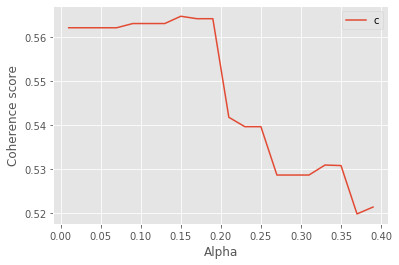

In [117]:
# Show graph
import matplotlib.pyplot as plt
x = list(np.arange(0.01, 0.4, 0.02))

plt.plot(x, coherence_values)
plt.xlabel("Alpha")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

- Alpha vlaue 0.1 or symmetric worked same

- Final Hyper parameters are:
  - Number of topics are 8
  - Alpha is 0.1 or symmetric
  - This gives a coherence score of 0.565 which is highest. 
   

In [126]:
# Final model using finalalized parameters
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=words,
                                            num_topics=8, 
                                            random_state=100,
                                            chunksize= 100,
                                            passes=10,
                                            alpha = 0.15,
                                            per_word_topics=True)
# Get Coherence Score using c_v
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=doc_list, 
                                     dictionary=words, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5647969790001925


In [149]:
pprint.pprint(lda_model.print_topics(num_words=20)) 

[(0,
  '0.030*"cell" + 0.023*"protein" + 0.011*"virus" + 0.009*"rna" + '
  '0.008*"viral" + 0.007*"use" + 0.007*"expression" + 0.005*"replication" + '
  '0.005*"gene" + 0.004*"infection" + 0.004*"1" + 0.004*"express" + 0.004*"s" '
  '+ 0.004*"membrane" + 0.004*"5" + 0.003*"sars-cov" + 0.003*"2" + '
  '0.003*"signal" + 0.003*"infect" + 0.003*"n"'),
 (1,
  '0.015*"case" + 0.012*"model" + 0.011*"covid-19" + 0.010*"numb" + '
  '0.010*"datum" + 0.008*"display" + 0.008*"1" + 0.008*"perpetuity" + '
  '0.008*"2020" + 0.008*"available" + 0.008*"time" + 0.007*"international" + '
  '0.007*"use" + 0.007*"4.0" + 0.007*"sars-cov-2" + 0.006*"2" + 0.006*"rate" + '
  '0.006*"epidemic" + 0.006*"population" + 0.006*"estimate"'),
 (2,
  '0.060*"de" + 0.033*"la" + 0.020*"en" + 0.016*"y" + 0.012*"que" + 0.011*"se" '
  '+ 0.010*"con" + 0.010*"los" + 0.007*"n" + 0.007*"del" + 0.006*"un" + '
  '0.006*"por" + 0.006*"las" + 0.006*"una" + 0.006*"para" + 0.005*"o" + '
  '0.005*"pacientes" + 0.004*"es" + 0.003*"com

In [128]:
#save final model by pickling
pkl_filename = "final_lda_model.pickle"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lda_model, file)

## Visualize topics

In [136]:
import pyLDAvis.gensim
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(topic_model = lda_model,
                                          corpus = corpus, 
                                          dictionary = lda_model.id2word)
pyLDAvis.show(LDAvis_prepared)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [20/May/2020 00:49:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2020 00:49:23] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2020 00:49:23] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2020 00:49:23] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2020 00:57:51] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2020 00:57:51] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2020 00:57:52] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2020 00:57:52] "GET / HTTP/1.1" 200 -
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 62086)
Traceback (most recent call last):
  File "/Users/srinivasaluri/anaconda/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/srinivasaluri/anaconda/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/srinivasalu


stopping Server...
